# Analyze the perirhinal searchlight cluster

In [1]:
import os
import numpy as np
import matplotlib as mpl
import pandas as pd
import pingouin as pg
import bambi as bmb
import arviz as az

from tesser import rsa
from tesser import tasks

bids_dir = os.environ['TESSER_BIDS']
res_dir = os.environ['TESSER_RESULTS']
fig_dir = os.path.join(os.environ['TESSER_FIGURES'], 'plots')
os.makedirs(fig_dir, exist_ok=True)
beta_dir = os.path.join(res_dir, 'beta', 'smooth4mm')

/Users/morton/anaconda3/envs/tesser2/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/Users/morton/anaconda3/envs/tesser2/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


## Load cluster pattern stats

In [2]:
roi = 'gray'
contrast = 'community_group'
stat = 'group'
cluster = 'prcl'
dilate = 2

subjects = tasks.get_subj_list()
patterns = []
for subject in subjects:
    mat, events = rsa.load_cluster_patterns(
        beta_dir, subject, roi, contrast, stat, cluster, dilate
    )
    patterns.append(mat)
sim = rsa.beta_sim_stats(events, patterns)
diff = sim['within'] - sim['across']

## Load induction task performance

In [3]:
induct_raw = tasks.load_induct(bids_dir)
induct = tasks.score_induct(induct_raw)
bias_trial = (
    induct.groupby(['subject', 'trial_type'])['correct']
    .mean()
    .unstack('trial_type')
)
bias_trial['diff'] = diff
m = induct.groupby('subject')['correct'].mean()
c = bias_trial['central'].to_numpy()
b1 = bias_trial['boundary1'].to_numpy()
b2 = bias_trial['boundary2'].to_numpy()

## Test relationships between pattern similarity and inference

In [4]:
x = np.vstack([np.ones(c.shape), c, b1, b2]).T
y = diff
pg.linear_regression(x, y)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.007933,0.003440,-2.305856,0.027542,0.170154,0.094714,-0.014933,-0.000934
1,x2,0.009400,0.005868,1.602031,0.118679,0.170154,0.094714,-0.002538,0.021338
2,x3,-0.005839,0.004055,-1.440076,0.159266,0.170154,0.094714,-0.014089,0.002410
3,x4,0.006424,0.003392,1.893874,0.067036,0.170154,0.094714,-0.000477,0.013325


In [5]:
model = bmb.Model('diff ~ central + boundary1 + boundary2', bias_trial)
model.build()

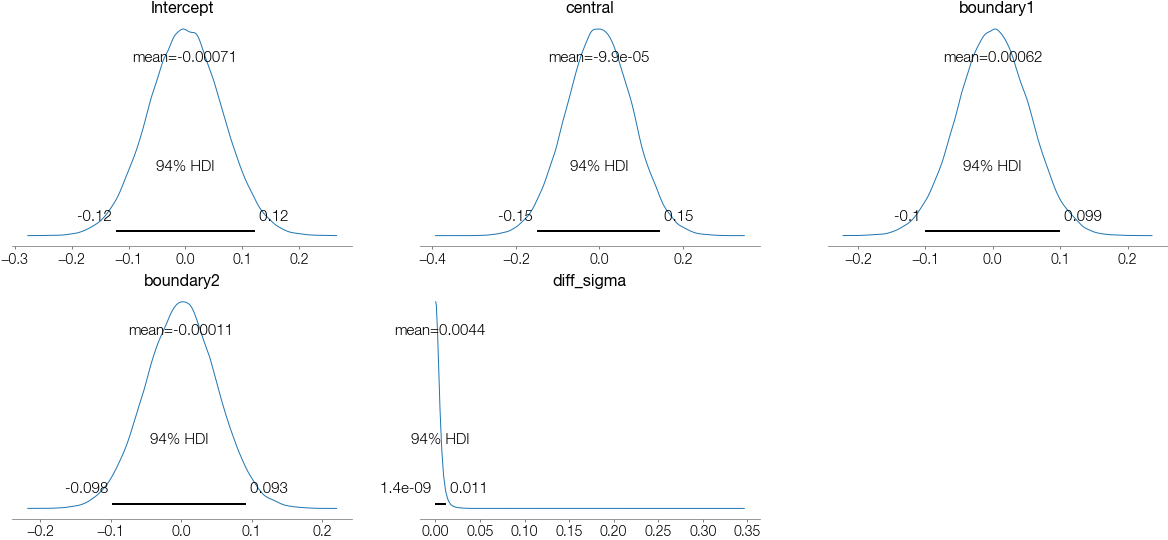

In [6]:
model.plot_priors(draws=100000);

In [7]:
results = model.fit(draws=2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [diff_sigma, boundary2, boundary1, central, Intercept]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


In [11]:
help(model.fit)

Help on method fit in module bambi.models:

fit(draws=1000, tune=1000, discard_tuned_samples=True, omit_offsets=True, include_mean=False, method='mcmc', init='auto', n_init=50000, chains=None, cores=None, random_seed=None, **kwargs) method of bambi.models.Model instance
    Fit the model using PyMC3.
    
    Parameters
    ----------
    draws: int
        The number of samples to draw from the posterior distribution. Defaults to 1000.
    tune : int
        Number of iterations to tune. Defaults to 1000. Samplers adjust the step sizes,
        scalings or similar during tuning. These tuning samples are be drawn in addition to the
        number specified in the ``draws`` argument, and will be discarded unless
        ``discard_tuned_samples`` is set to ``False``.
    discard_tuned_samples : bool
        Whether to discard posterior samples of the tune interval. Defaults to ``True``.
    omit_offsets: bool
        Omits offset terms in the ``InferenceData`` object returned when the mo

In [14]:
import pymc3 as pm
help(pm.sample)

Help on function sample in module pymc3.sampling:

sample(draws=1000, step=None, init='auto', n_init=200000, start=None, trace=None, chain_idx=0, chains=None, cores=None, tune=1000, progressbar=True, model=None, random_seed=None, discard_tuned_samples=True, compute_convergence_checks=True, callback=None, jitter_max_retries=10, *, return_inferencedata=None, idata_kwargs: dict = None, mp_ctx=None, pickle_backend: str = 'pickle', **kwargs)
    Draw samples from the posterior using the given step methods.
    
    Multiple step methods are supported via compound step methods.
    
    Parameters
    ----------
    draws : int
        The number of samples to draw. Defaults to 1000. The number of tuned samples are discarded
        by default. See ``discard_tuned_samples``.
    init : str
        Initialization method to use for auto-assigned NUTS samplers.
    
        * auto: Choose a default initialization method automatically.
          Currently, this is ``jitter+adapt_diag``, but this

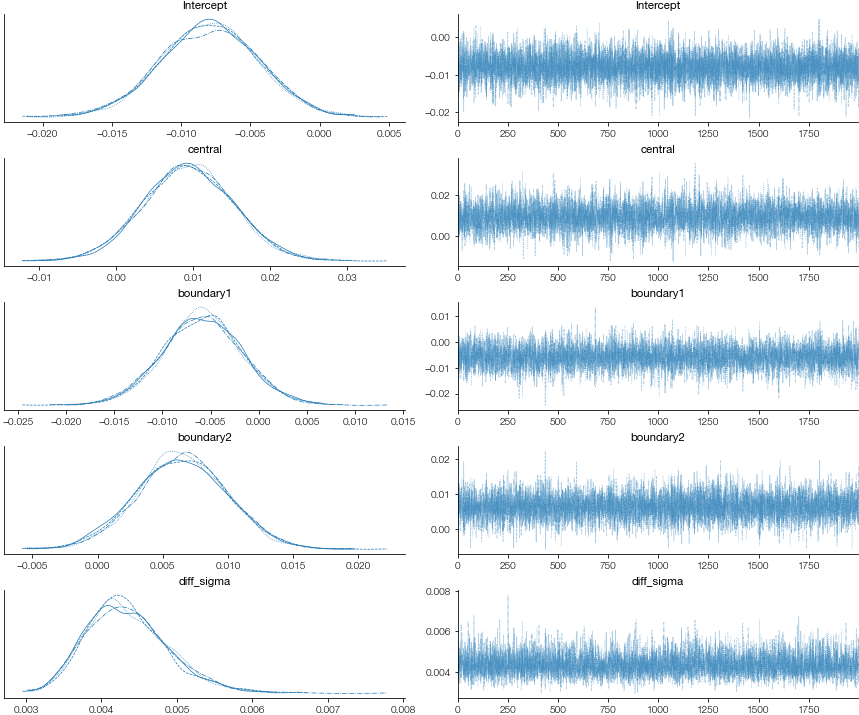

In [8]:
with mpl.rc_context({'figure.constrained_layout.use': True}):
    az.plot_trace(results);

In [9]:
pd.options.display.float_format = "{:,.4f}".format
summary = az.summary(results, hdi_prob=0.95)
summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.0080,0.0040,-0.0150,-0.0010,0.0000,0.0000,"9,584.0000","7,029.0000",1.0000
central,0.0090,0.0060,-0.0020,0.0210,0.0000,0.0000,"5,983.0000","5,828.0000",1.0000
boundary1,-0.0060,0.0040,-0.0140,0.0030,0.0000,0.0000,"5,582.0000","5,569.0000",1.0000
boundary2,0.0060,0.0030,-0.0010,0.0130,0.0000,0.0000,"7,273.0000","5,566.0000",1.0000
diff_sigma,0.0040,0.0010,0.0030,0.0050,0.0000,0.0000,"5,976.0000","4,866.0000",1.0000


In [15]:
summary.min()

mean           -0.0080
sd              0.0010
hdi_2.5%       -0.0150
hdi_97.5%      -0.0010
mcse_mean       0.0000
mcse_sd         0.0000
ess_bulk    5,582.0000
ess_tail    4,866.0000
r_hat           1.0000
dtype: float64

In [10]:
%load_ext watermark
%watermark -i -m -v -iv

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.28.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

numpy     : 1.21.2
matplotlib: 3.4.3
bambi     : 0.7.1
arviz     : 0.11.4
pingouin  : 0.5.0
tesser    : 1.0.0
pandas    : 1.3.3

